# Data Analysis & Plots

Total typhoons found: 480
Analyzing frame distribution across all typhoons...


Counting frames: 100%|██████████████████████| 480/480 [00:00<00:00, 3306.76it/s]


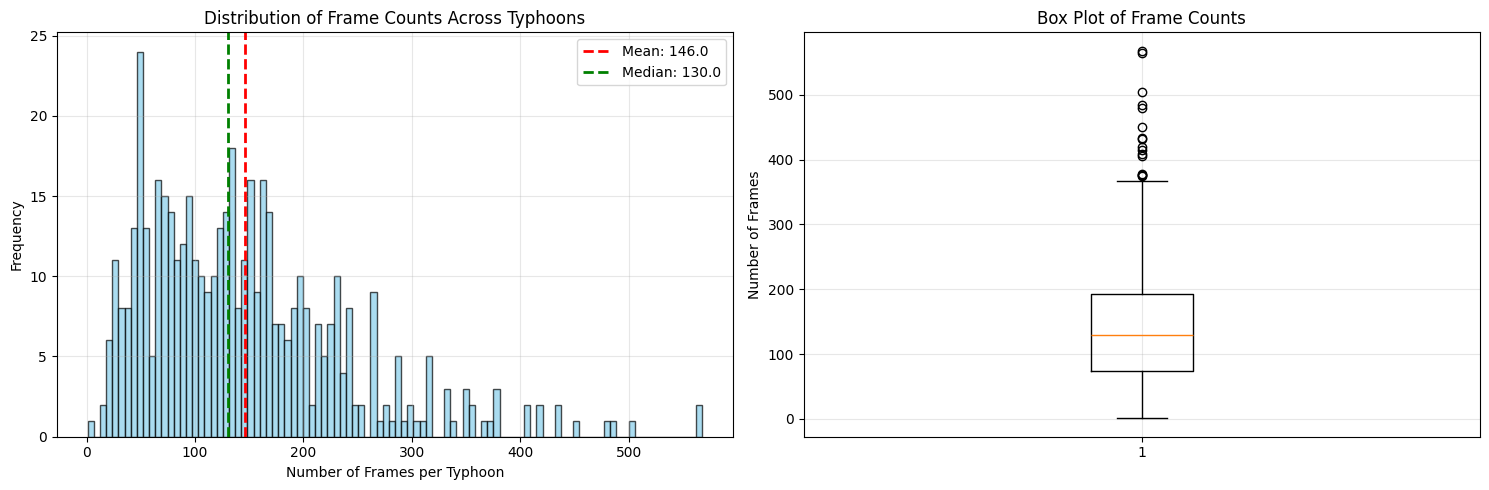


FRAME DISTRIBUTION ANALYSIS RESULTS
Total number of typhoons: 480
Total number of frames: 70087
Minimum frames per typhoon: 1
Maximum frames per typhoon: 568
Mean frames per typhoon: 146.01
Median frames per typhoon: 130.00
Standard deviation: 94.72

Typhoons with minimum frames (1):
  - 200308

Typhoons with maximum frames (568):
  - 199402

Typhoons with insufficient frames (< 11): 1
Examples:
  - 200308 (1 frames)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- CONFIGURATION ------------------------------------------------
BASE_DIR = "./data/AU"
IMAGE_DIR = os.path.join(BASE_DIR, "image")
# -----------------------------------------------------------------

# ================================================================
# UTILITIES
# ================================================================
def list_h5_files(typhoon_id):
    """Return list of .h5 files for a given typhoon."""
    img_dir = os.path.join(IMAGE_DIR, typhoon_id)
    return sorted([
        os.path.join(img_dir, f)
        for f in os.listdir(img_dir)
        if f.lower().endswith(".h5")
    ])

typhoon_ids = sorted([
    name for name in os.listdir(IMAGE_DIR)
    if os.path.isdir(os.path.join(IMAGE_DIR, name))
])
print(f"Total typhoons found: {len(typhoon_ids)}")

# ================================================================
# FRAME DISTRIBUTION ANALYSIS
# ================================================================

def analyze_frame_distribution(typhoon_ids):
    """
    Analyze the distribution of frames (HDF5 files) across all typhoons.
    """
    frame_counts = []
    frame_details = {}
    
    print("Analyzing frame distribution across all typhoons...")
    
    for typhoon_id in tqdm(typhoon_ids, desc="Counting frames"):
        h5_files = list_h5_files(typhoon_id)
        frame_count = len(h5_files)
        frame_counts.append(frame_count)
        frame_details[typhoon_id] = frame_count

    min_frames = np.min(frame_counts)
    max_frames = np.max(frame_counts)
    mean_frames = np.mean(frame_counts)
    median_frames = np.median(frame_counts)
    std_frames = np.std(frame_counts)
    
    min_typhoons = [tid for tid, count in frame_details.items() if count == min_frames]
    max_typhoons = [tid for tid, count in frame_details.items() if count == max_frames]
    
    results = {
        'min_frames': min_frames,
        'max_frames': max_frames,
        'mean_frames': mean_frames,
        'median_frames': median_frames,
        'std_frames': std_frames,
        'total_typhoons': len(typhoon_ids),
        'total_frames': sum(frame_counts),
        'min_typhoons': min_typhoons,
        'max_typhoons': max_typhoons,
        'frame_counts': frame_counts,
        'frame_details': frame_details
    }
    
    return results


def plot_frame_histogram(frame_counts, results):
    """
    Plot histogram and boxplot showing distribution of frame counts.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.hist(frame_counts, bins=100, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(results['mean_frames'], color='red', linestyle='--', linewidth=2, 
                label=f"Mean: {results['mean_frames']:.1f}")
    ax1.axvline(results['median_frames'], color='green', linestyle='--', linewidth=2, 
                label=f"Median: {results['median_frames']:.1f}")
    ax1.set_xlabel('Number of Frames per Typhoon')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Frame Counts Across Typhoons')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.boxplot(frame_counts, vert=True)
    ax2.set_ylabel('Number of Frames')
    ax2.set_title('Box Plot of Frame Counts')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def print_frame_statistics(results):
    """
    Print detailed statistics about frame distribution.
    """
    print("\n" + "="*60)
    print("FRAME DISTRIBUTION ANALYSIS RESULTS")
    print("="*60)
    print(f"Total number of typhoons: {results['total_typhoons']}")
    print(f"Total number of frames: {results['total_frames']}")
    print(f"Minimum frames per typhoon: {results['min_frames']}")
    print(f"Maximum frames per typhoon: {results['max_frames']}")
    print(f"Mean frames per typhoon: {results['mean_frames']:.2f}")
    print(f"Median frames per typhoon: {results['median_frames']:.2f}")
    print(f"Standard deviation: {results['std_frames']:.2f}")
    
    print(f"\nTyphoons with minimum frames ({results['min_frames']}):")
    for typhoon in results['min_typhoons']:
        print(f"  - {typhoon}")
    
    print(f"\nTyphoons with maximum frames ({results['max_frames']}):")
    for typhoon in results['max_typhoons']:
        print(f"  - {typhoon}")

    #Discard samples with 10 frames or less
    
    insufficient_frames = [tid for tid, count in results['frame_details'].items() if count < 11]
    print(f"\nTyphoons with insufficient frames (< 11): {len(insufficient_frames)}")
    if insufficient_frames:
        print("Examples:")
        for typhoon in insufficient_frames[:10]:
            print(f"  - {typhoon} ({results['frame_details'][typhoon]} frames)")
        if len(insufficient_frames) > 10:
            print(f"  ... and {len(insufficient_frames) - 10} more")

frame_results = analyze_frame_distribution(typhoon_ids)
plot_frame_histogram(frame_results['frame_counts'], frame_results)
print_frame_statistics(frame_results)

Computing average grade per typhoon per year...


Processing typhoons: 100%|███████████████████| 480/480 [00:00<00:00, 847.58it/s]


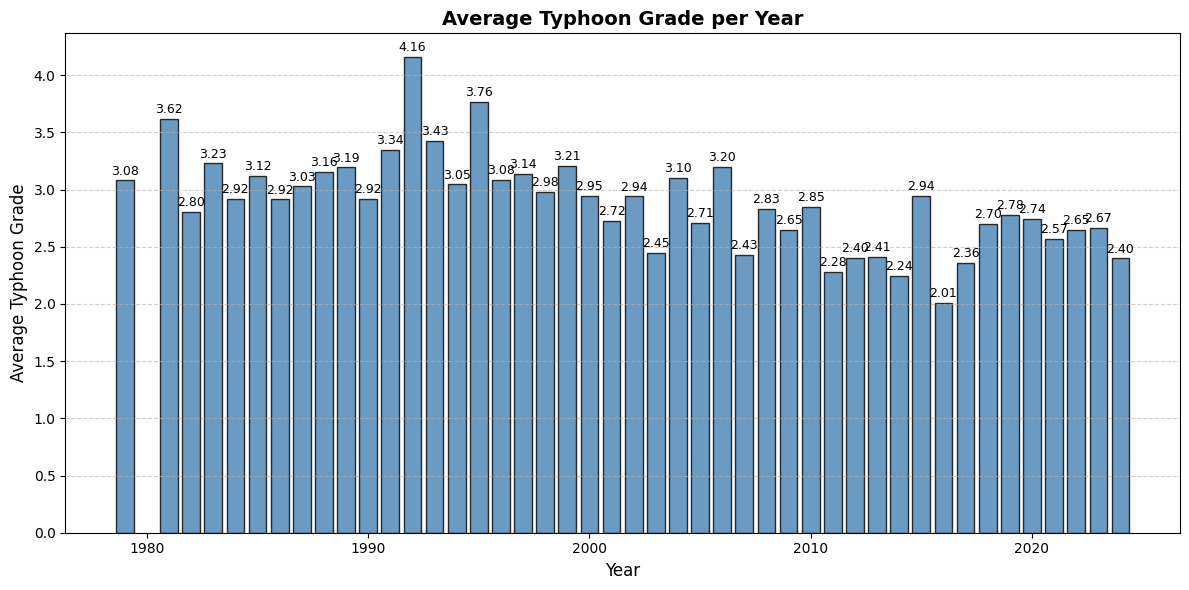


Computing maximum grade per typhoon...


Processing typhoons for max grade: 100%|█████| 480/480 [00:00<00:00, 857.80it/s]


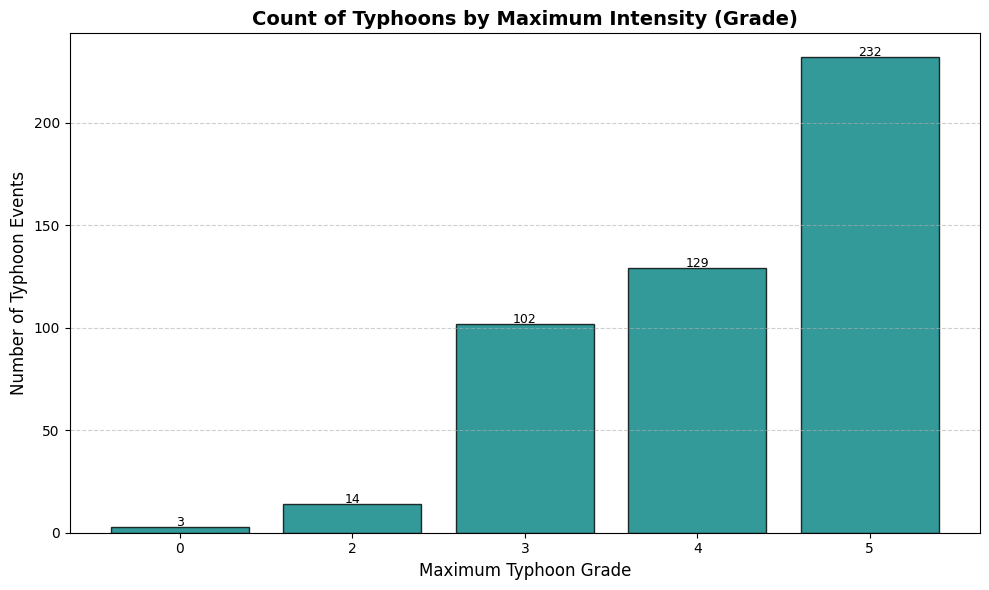


Computing typhoon grade ranges with years...


Processing typhoons for grade range + year: 100%|█| 480/480 [00:00<00:00, 793.35


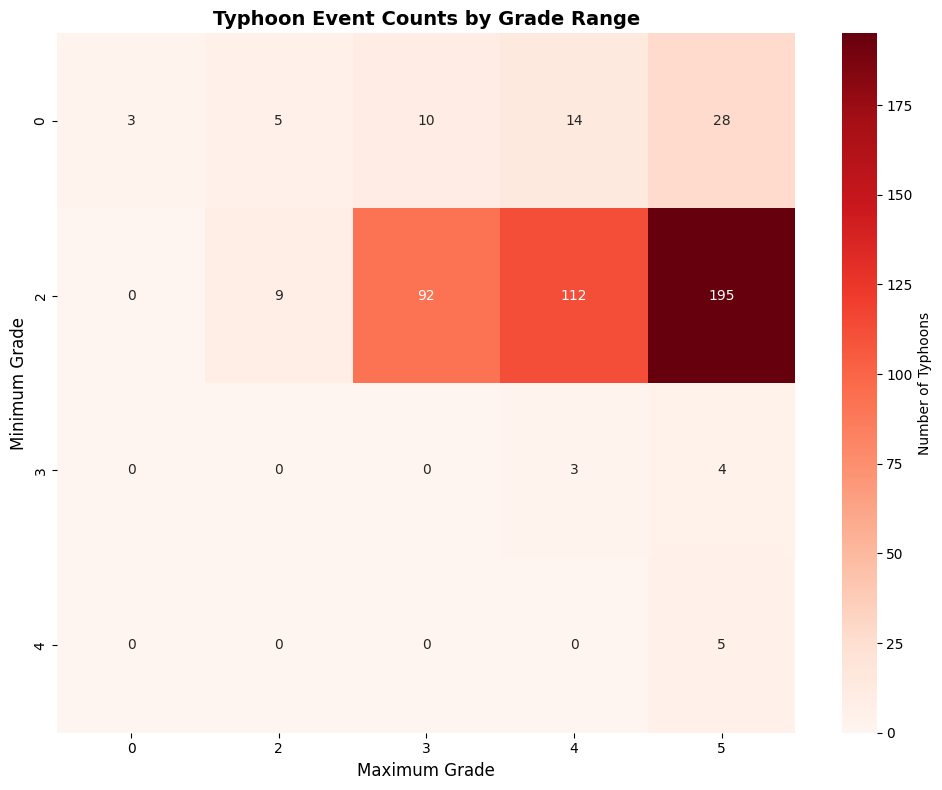

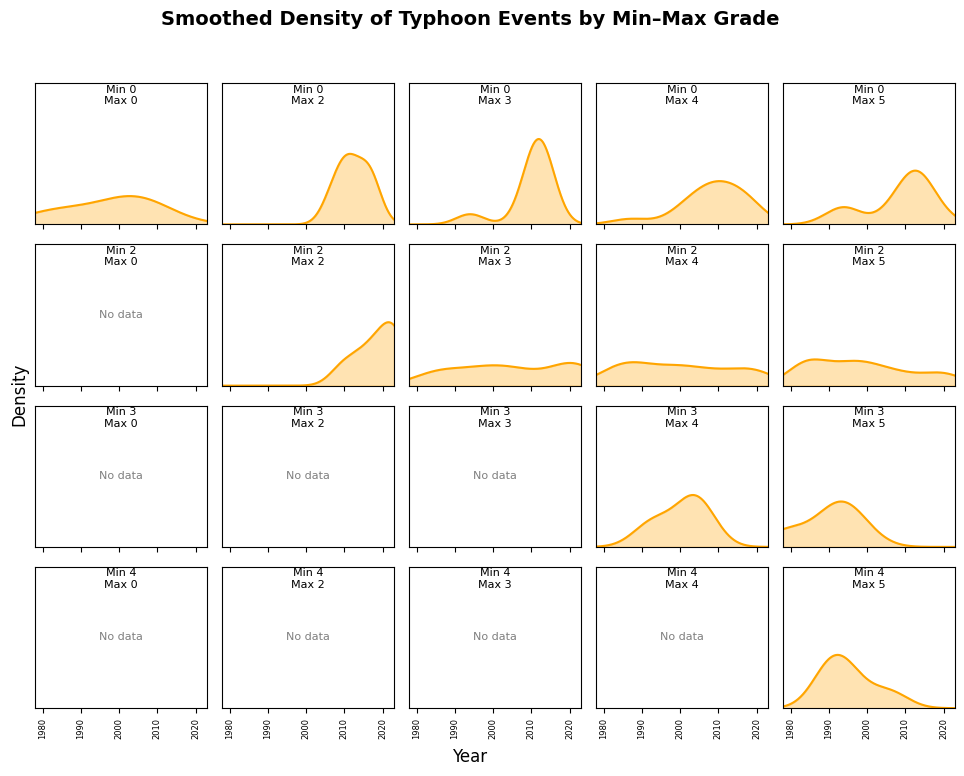

In [2]:
# ================================================================
# METADATA LOADING FUNCTION
# ================================================================
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import gaussian_kde

BASE_DIR = "./data/AU"
META_DIR = os.path.join(BASE_DIR, "metadata")

def load_typhoon_metadata(typhoon_id):
    """Load metadata CSV for a given typhoon."""
    csv_path = os.path.join(META_DIR, f"{typhoon_id}.csv")
    if not os.path.exists(csv_path):
        print(f"[WARN] Metadata not found for {typhoon_id}")
        return None
    try:
        return pd.read_csv(csv_path)
    except Exception as e:
        print(f"[ERROR] Could not read metadata for {typhoon_id}: {e}")
        return None

def extract_year(typhoon_id):
    match = re.match(r"(\d{4})", typhoon_id)
    return int(match.group(1)) if match else None

# ================================================================
# AVERAGE TYHOON GRADE PER YEAR
# ================================================================
year_grades = {}

print("Computing average grade per typhoon per year...")
for typhoon_id in tqdm(typhoon_ids, desc="Processing typhoons"):
    meta = load_typhoon_metadata(typhoon_id)
    if meta is None or "grade" not in meta.columns:
        continue

    avg_grade = meta["grade"].mean()
    year = extract_year(typhoon_id)
    if year is None:
        continue

    year_grades.setdefault(year, []).append(avg_grade)

avg_grade_per_year = {year: np.mean(grades) for year, grades in year_grades.items()}

years = sorted(avg_grade_per_year.keys())
avg_grades = [avg_grade_per_year[y] for y in years]

plt.figure(figsize=(12, 6))
plt.bar(years, avg_grades, color='steelblue', edgecolor='black', alpha=0.8)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Typhoon Grade", fontsize=12)
plt.title("Average Typhoon Grade per Year", fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)

for i, v in enumerate(avg_grades):
    plt.text(years[i], v + 0.05, f"{v:.2f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# ================================================================
# MAXIMUM INTENSITY COUNTS
# ================================================================
max_grades = []

print("\nComputing maximum grade per typhoon...")
for typhoon_id in tqdm(typhoon_ids, desc="Processing typhoons for max grade"):
    meta = load_typhoon_metadata(typhoon_id)
    if meta is None or "grade" not in meta.columns:
        continue

    max_grade = meta["grade"].max()
    if pd.notnull(max_grade):
        max_grades.append(max_grade)

grade_counts = pd.Series(max_grades).value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(grade_counts.index.astype(str),
               grade_counts.values,
               color='teal',
               edgecolor='black',
               alpha=0.8)

plt.xlabel("Maximum Typhoon Grade", fontsize=12)
plt.ylabel("Number of Typhoon Events", fontsize=12)
plt.title("Count of Typhoons by Maximum Intensity (Grade)", fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,
             height + 0.5,
             f"{int(height)}",
             ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# ================================================================
# TYPHOON GRADE RANGE ANALYSIS
# ================================================================
print("\nComputing typhoon grade ranges with years...")
grade_ranges_with_year = []

for typhoon_id in tqdm(typhoon_ids, desc="Processing typhoons for grade range + year"):
    meta = load_typhoon_metadata(typhoon_id)
    if meta is None or "grade" not in meta.columns:
        continue

    grades = meta["grade"].dropna()
    if grades.empty:
        continue

    min_g = int(grades.min())
    max_g = int(grades.max())
    year = extract_year(typhoon_id)
    if year is None:
        continue

    grade_ranges_with_year.append((min_g, max_g, year))

range_df = pd.DataFrame(grade_ranges_with_year, columns=["min_grade", "max_grade", "year"])

heatmap_counts = range_df.groupby(["min_grade", "max_grade"]).size().unstack(fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_counts, annot=True, fmt="d", cmap="Reds", cbar_kws={'label': 'Number of Typhoons'})
plt.xlabel("Maximum Grade", fontsize=12)
plt.ylabel("Minimum Grade", fontsize=12)
plt.title("Typhoon Event Counts by Grade Range", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ================================================================
# DENSITY PLOTS OVER YEARS FOR EACH GRADE RANGE
# ================================================================
min_grades = sorted(range_df["min_grade"].unique())
max_grades = sorted(range_df["max_grade"].unique())

fig, axes = plt.subplots(len(min_grades), len(max_grades),
                         figsize=(2*len(max_grades), 2*len(min_grades)),
                         sharex=True, sharey=True)

if len(min_grades) == 1 and len(max_grades) == 1:
    axes = np.array([[axes]])
elif len(min_grades) == 1:
    axes = axes[np.newaxis, :]
elif len(max_grades) == 1:
    axes = axes[:, np.newaxis]

for i, min_g in enumerate(min_grades):
    for j, max_g in enumerate(max_grades):
        ax = axes[i, j]
        years = range_df[(range_df["min_grade"] == min_g) &
                         (range_df["max_grade"] == max_g)]["year"].values
        ax.set_xlim(1978, 2023)
        ax.set_ylim(0, 0.15)
        ax.set_xticks(np.arange(1980, 2025, 10))
        ax.set_yticks([])
        ax.set_xticklabels([str(year) for year in np.arange(1980, 2025, 10)],
                           rotation=90, fontsize=6)

        if len(years) >= 2:
            kde = gaussian_kde(years)
            x_vals = np.linspace(1978, 2023, 500)
            y_vals = kde(x_vals)
            ax.plot(x_vals, y_vals, color='orange')
            ax.fill_between(x_vals, 0, y_vals, color='orange', alpha=0.3)
        else:
            ax.text(0.5, 0.5, "No data", transform=ax.transAxes,
                    ha='center', va='center', fontsize=8, color='gray')

        ax.text(0.5, 0.85, f"Min {min_g}\nMax {max_g}",
                transform=ax.transAxes, ha='center', fontsize=8)

fig.text(0.5, 0.04, 'Year', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=12)
fig.suptitle("Smoothed Density of Typhoon Events by Min–Max Grade", fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()

Processing metadata: 100%|███████████████████| 480/480 [00:00<00:00, 725.96it/s]


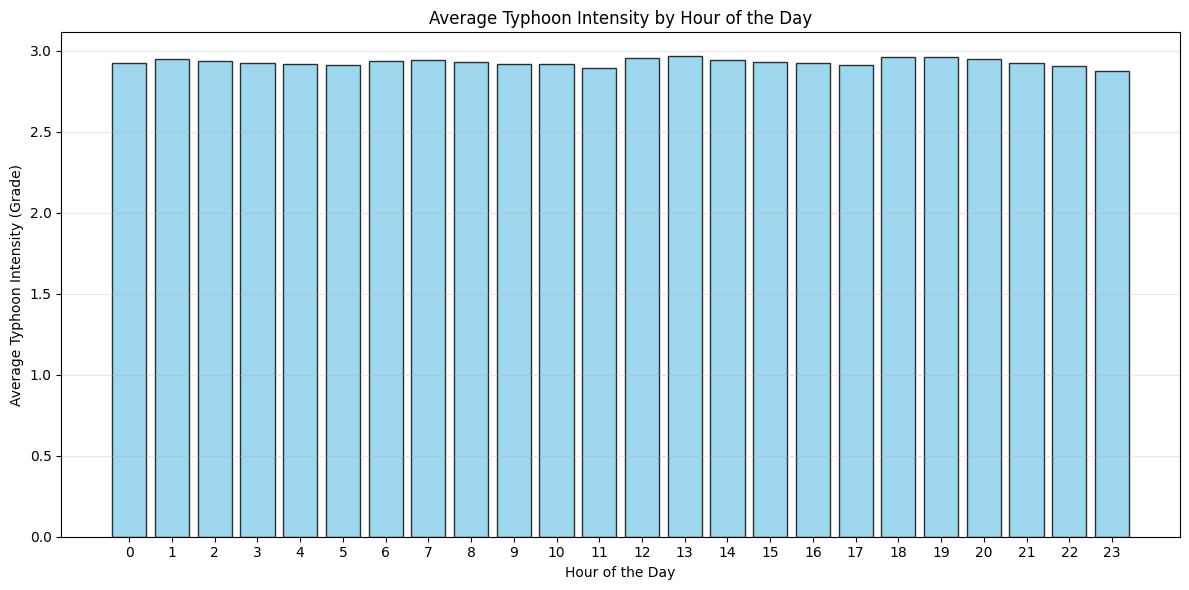

In [3]:
# ================================================================
# AVERAGE INTENSITY BY HOUR OF THE DAY
# ================================================================
import glob
import pandas as pd
import matplotlib.pyplot as plt

all_hours = []
all_grades = []

for csv_fp in tqdm(sorted(glob.glob(os.path.join(META_DIR, "*.csv"))), desc="Processing metadata"):
    try:
        df = pd.read_csv(csv_fp)
    except Exception as e:
        print(f"Could not read {csv_fp}: {e}")
        continue

    if {"hour", "grade"} <= set(df.columns):
        hours = df["hour"].dropna().astype(int)
        grades = df["grade"].dropna().astype(float)
        all_hours.extend(hours)
        all_grades.extend(grades)

hour_df = pd.DataFrame({"hour": all_hours, "grade": all_grades})

avg_grade_by_hour = hour_df.groupby("hour")["grade"].mean()

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(avg_grade_by_hour.index, avg_grade_by_hour.values, color='skyblue', edgecolor='black', alpha=0.8)
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Average Typhoon Intensity (Grade)")
ax.set_title("Average Typhoon Intensity by Hour of the Day")
ax.set_xticks(range(0,24))
ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
#!pip install imageio
#!pip install cartopy

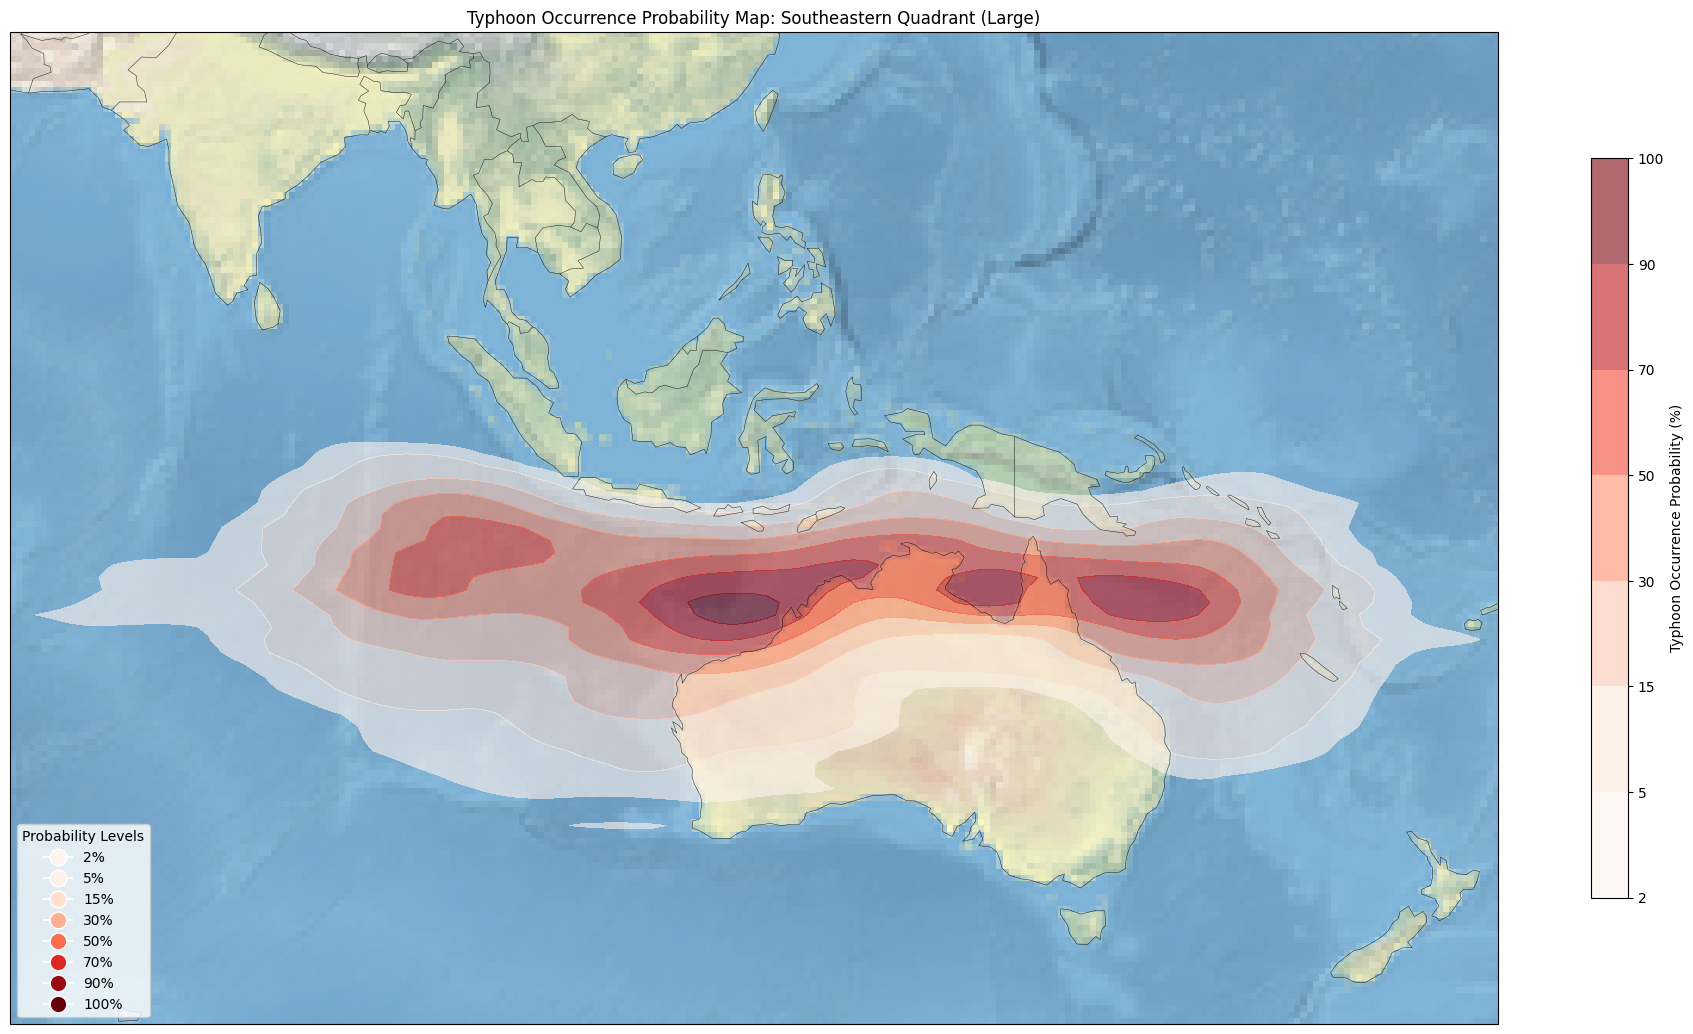

In [5]:
# ================================================================
# Load Metadata with Grade + Position
# ================================================================
def load_typhoon_data(typhoon_id):
    """
    Load metadata (including grade, lon, lat) and image paths for a typhoon.
    Returns a tuple: (metadata DataFrame, list of image paths)
    """
    meta_df = load_typhoon_metadata(typhoon_id)
    if meta_df is None:
        return None, None

    expected_cols = {"grade", "lat", "lng"}
    missing = expected_cols - set(meta_df.columns)
    if missing:
        print(f"[WARN] Missing columns {missing} in metadata for {typhoon_id}")

    img_files = list_h5_files(typhoon_id)
    if not img_files:
        print(f"[WARN] No HDF5 images found for {typhoon_id}")
        return meta_df, None

    n_meta = len(meta_df)
    n_imgs = len(img_files)
    #if n_meta != n_imgs:
        #print(f"[INFO] Metadata rows ({n_meta}) != image files ({n_imgs}) for {typhoon_id}")
    return meta_df, img_files

# ================================================================
# Collect all points and compute probability density
# ================================================================
from scipy.stats import gaussian_kde
from matplotlib.lines import Line2D

def collect_all_typhoon_points(typhoon_ids):
    """
    Collect all lat/lon points and grades for all typhoons.
    Returns a DataFrame with columns: 'lat', 'lon', 'grade'.
    """
    all_points=[]
    for tid in typhoon_ids:
        meta_df,_=load_typhoon_data(tid)
        if meta_df is not None:
            loncol = "lng" if "lng" in meta_df.columns else "lon"
            all_points.append(meta_df[["lat",loncol,"grade"]].rename(columns={loncol:"lng"}))
    return pd.concat(all_points,ignore_index=True) if all_points else pd.DataFrame(columns=["lat","lng","grade"])

def compute_typhoon_density(df, grid_res=1.0):
    """
    Compute 2D KDE of typhoon occurrence locations.
    Returns X, Y meshgrid and normalized density Z (0-100%).
    """
    lats = df["lat"].values
    lons = df["lng"].values
    lat_grid = np.arange(-90,90+grid_res,grid_res)
    lon_grid = np.arange(-180,180+grid_res,grid_res)
    X,Y = np.meshgrid(lon_grid,lat_grid)
    positions = np.vstack([lons,lats])
    values = np.vstack([X.ravel(),Y.ravel()])
    kde = gaussian_kde(positions)
    Z = np.reshape(kde(values),X.shape)
    Z = 100*Z/Z.max()  # normalize to percentage
    return X,Y,Z

# ================================================================
# Plot probability density as Gaussian-like bubbles
# ================================================================

def plot_typhoon_probability_map_southeast_large(X, Y, Z, levels=[5,15,30,50,70], cmap="Reds"):
    """
    Plot typhoon occurrence probability as Gaussian-like bubbles,
    fixed to the southeastern quadrant (India → Australasia), with a 2x larger figure.
    """
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from matplotlib.lines import Line2D

    #Fixed SE Asia / Australasia region
    lat_min, lat_max = -50, 30
    lon_min, lon_max = 60, 180

    fig = plt.figure(figsize=(24,16))  # 2x larger than previous (12x8)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.stock_img()
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.3)

    cf = ax.contourf(X, Y, Z, levels=levels, cmap=cmap, alpha=0.6, transform=ccrs.PlateCarree())

    cbar = plt.colorbar(cf, orientation="vertical", shrink=0.6, pad=0.05)
    cbar.set_label("Typhoon Occurrence Probability (%)")

    legend_elements = [Line2D([0],[0], marker='o', color='w', label=f"{lvl}%",
                              markerfacecolor=cf.cmap(cf.norm(lvl)), markersize=12) for lvl in levels]
    ax.legend(handles=legend_elements, loc="lower left", title="Probability Levels", fontsize=10)

    ax.set_title("Typhoon Occurrence Probability Map: Southeastern Quadrant (Large)")
    plt.show()


all_points_df = collect_all_typhoon_points(typhoon_ids)
X, Y, Z = compute_typhoon_density(all_points_df, grid_res=1.0)
plot_typhoon_probability_map_southeast_large(X, Y, Z, levels=[2,5,15,30,50,70,90,100], cmap="Reds")

# Frame Plotting & Typhoon Trajectory

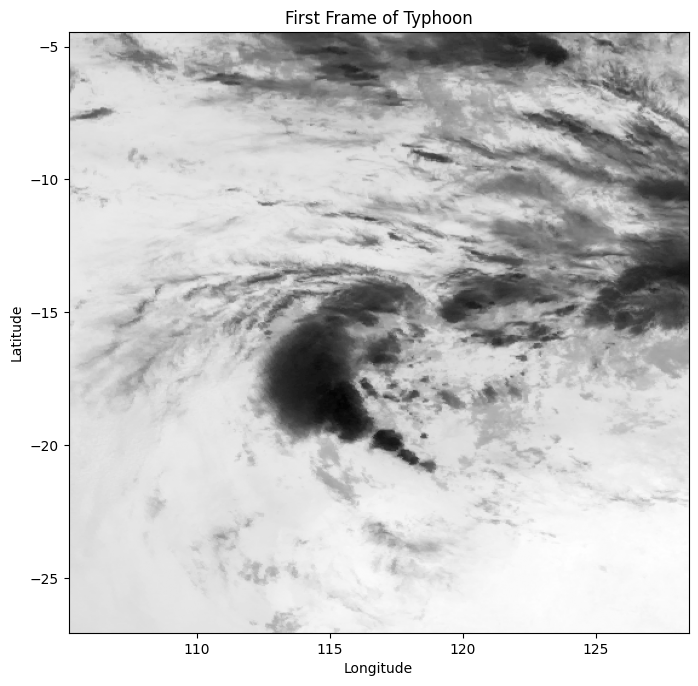

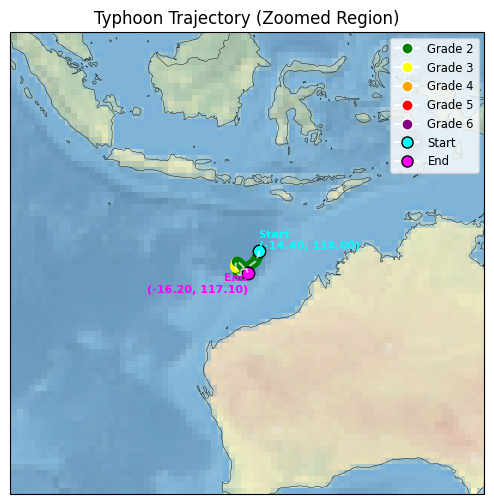

In [6]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import imageio
import io
from tqdm import tqdm
from IPython.display import Image, display
import h5py

grade_colors = {
    2: "green",
    3: "yellow",
    4: "orange",
    5: "red",
    6: "purple"
}

def compute_degree_extent(lat_center, crop_radius_km=1250.0):
    """
    Approximate degrees per km around given latitude.
    """
    km_per_deg_lat = 110.574
    km_per_deg_lon = 111.320 * np.cos(np.deg2rad(lat_center))
    dlat = crop_radius_km / km_per_deg_lat
    dlon = crop_radius_km / km_per_deg_lon
    return dlat, dlon


def plot_typhoon_frames(meta_df, img_files, dataset_key=None, animate=False, duration=200,
                        buffer_km=1250, save_path=None):
    """
    Show the first frame or create a GIF of all frames for a typhoon.

    Args:
        meta_df: Typhoon metadata DataFrame with 'lat', 'lon'/'lng', 'grade'.
        img_files: List of HDF5 image paths.
        dataset_key: Optional dataset key in HDF5 files.
        animate: If True, create a GIF of all frames; else show first frame.
        duration: Frame duration in ms for GIF.
        buffer_km: Buffer distance for geographic extent in km.
        save_path: Optional output file path for GIF.
    """
    loncol = "lng" if "lng" in meta_df.columns else "lon"

    #Compute geographic extent based on metadata center
    lat_center = meta_df["lat"].mean()
    lon_center = meta_df[loncol].mean()
    
    def km_to_deg_lat(km):
        return km / 110.574

    def km_to_deg_lon(km, lat):
        return km / (111.320 * np.cos(np.deg2rad(lat)))

    lat_buffer = km_to_deg_lat(buffer_km)
    lon_buffer = km_to_deg_lon(buffer_km, lat_center)

    lat_min, lat_max = lat_center - lat_buffer, lat_center + lat_buffer
    lon_min, lon_max = lon_center - lon_buffer, lon_center + lon_buffer

    #Single Frame 
    
    if not animate:
        with h5py.File(img_files[0], "r") as f:
            key = dataset_key or list(f.keys())[0]
            img = np.array(f[key])
            if img.ndim == 3:
                img = img[0]

        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(img, cmap="gray", extent=[lon_min, lon_max, lat_min, lat_max], origin="upper")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.set_title("First Frame of Typhoon")
        plt.show()
        return

    #Animated GIF
    frames = []
    for h5_path in tqdm(img_files, desc="Creating GIF frames"):
        with h5py.File(h5_path, "r") as f:
            key = dataset_key or list(f.keys())[0]
            img = np.array(f[key])
            if img.ndim == 3:
                img = img[0]

        fig, ax = plt.subplots(figsize=(6, 6), dpi=120)
        ax.imshow(img, cmap="gray", extent=[lon_min, lon_max, lat_min, lat_max], origin="upper")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.set_title("Typhoon Evolution")
        plt.tight_layout()

        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight')
        plt.close(fig)
        buf.seek(0)
        frames.append(imageio.v3.imread(buf))

    if save_path is None:
        save_path = "typhoon.gif"
    imageio.mimsave(save_path, frames, duration=duration / 1000.0)
    print(f"[INFO] Saved GIF → {save_path}")

    display(Image(filename=save_path))
    
def plot_typhoon_trajectory_world(meta_df, buffer_km=1000):
    """
    Plot typhoon trajectory on a zoomed-in world map with start/end coordinates labeled.
    
    Args:
        meta_df: Typhoon metadata DataFrame with 'lat', 'lon'/'lng', 'grade'.
        buffer_km: Extra distance to add around typhoon path in km.
    """
    loncol = "lng" if "lng" in meta_df.columns else "lon"
    grades = meta_df["grade"].astype(int).values
    track_colors = [grade_colors.get(g, "gray") for g in grades]

    start_lat, start_lon = meta_df["lat"].iloc[0], meta_df[loncol].iloc[0]
    end_lat, end_lon = meta_df["lat"].iloc[-1], meta_df[loncol].iloc[-1]

    lat_min, lat_max = meta_df["lat"].min(), meta_df["lat"].max()
    lon_min, lon_max = meta_df[loncol].min(), meta_df[loncol].max()

    def km_to_deg_lat(km):
        return km / 110.574

    def km_to_deg_lon(km, lat):
        return km / (111.320 * np.cos(np.deg2rad(lat)))

    lat_buffer = km_to_deg_lat(buffer_km)
    lon_buffer = km_to_deg_lon(buffer_km, (lat_min + lat_max)/2)

    zoom_lat_min = lat_min - lat_buffer
    zoom_lat_max = lat_max + lat_buffer
    zoom_lon_min = lon_min - lon_buffer
    zoom_lon_max = lon_max + lon_buffer

    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from matplotlib.lines import Line2D

    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([zoom_lon_min, zoom_lon_max, zoom_lat_min, zoom_lat_max], crs=ccrs.PlateCarree())
    ax.stock_img()
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.3)

    ax.plot(meta_df[loncol], meta_df["lat"], color="white", linestyle="--", alpha=0.7, transform=ccrs.PlateCarree())
    ax.scatter(meta_df[loncol], meta_df["lat"], c=track_colors, s=40, transform=ccrs.PlateCarree())

    ax.scatter([start_lon], [start_lat], c="cyan", s=80, edgecolor="black", transform=ccrs.PlateCarree(), label="Start")
    ax.scatter([end_lon], [end_lat], c="magenta", s=80, edgecolor="black", transform=ccrs.PlateCarree(), label="End")

    ax.text(start_lon, start_lat, f"Start\n({start_lat:.2f}, {start_lon:.2f})",
            color="cyan", fontsize=8, ha="left", va="bottom", weight="bold", transform=ccrs.PlateCarree())
    ax.text(end_lon, end_lat, f"End\n({end_lat:.2f}, {end_lon:.2f})",
            color="magenta", fontsize=8, ha="right", va="top", weight="bold", transform=ccrs.PlateCarree())

    legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Grade {g}',
                              markerfacecolor=c, markersize=8) for g, c in grade_colors.items()]
    legend_elements += [
        Line2D([0], [0], marker='o', color='w', label='Start', markerfacecolor='cyan', markeredgecolor='black', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='End', markerfacecolor='magenta', markeredgecolor='black', markersize=8)
    ]
    ax.legend(handles=legend_elements, loc="upper right", fontsize="small")

    ax.set_title("Typhoon Trajectory (Zoomed Region)")
    plt.show()

import random

random_id = random.choice(typhoon_ids)
meta_df, img_files = load_typhoon_data(random_id)

plot_typhoon_frames(meta_df, img_files, animate=False)

plot_typhoon_trajectory_world(meta_df, buffer_km=2000)